### Requirements

In [1]:
%pip install torch
%pip install -q bitsandbytes sentencepiece accelerate loralib datasets peft
%pip install torch
%pip install pillow
%pip install transformers
%pip install pandas numpy matplotlib
%pip install ipywidgets ipykernel

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

### Device

In [2]:
import torch
import torchvision.transforms as transforms
from transformers import IdeficsForVisionText2Text, AutoProcessor, Trainer, TrainingArguments, BitsAndBytesConfig
from datasets import load_dataset
from peft import get_peft_model, LoraConfig
from PIL import Image
import random
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    device_properties = torch.cuda.get_device_properties(0)  # Assuming you're using the first CUDA device
    print(f"Device Name: {device_properties.name}")
    print(f"Total Memory: {device_properties.total_memory / 1024**3:.2f} GB")
    print(f"Compute Capability: {device_properties.major}.{device_properties.minor}")
else:
    print("Using CPU")

Device Name: Tesla V100-SXM2-16GB
Total Memory: 15.77 GB
Compute Capability: 7.0


### Base Model

In [4]:
scenario = "scenario"

In [5]:
checkpoint = "HuggingFaceM4/idefics-9b"
checkpoint = "HuggingFaceM4/idefics-9b-instruct"
#checkpoint = "HuggingFaceM4/tiny-random-idefics"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_skip_modules=["lm_head", "embed_tokens"]
)
processor = AutoProcessor.from_pretrained(checkpoint)
model = IdeficsForVisionText2Text.from_pretrained(checkpoint, quantization_config=bnb_config, device_map="auto")
model

preprocessor_config.json:   0%|          | 0.00/283 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/99.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/7.89G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

IdeficsForVisionText2Text(
  (model): IdeficsModel(
    (embed_tokens): IdeficsDecoupledEmbedding(
      num_embeddings=32000, num_additional_embeddings=3, embedding_dim=4096, partially_freeze=False
      (additional_embedding): Embedding(3, 4096)
    )
    (vision_model): IdeficsVisionTransformer(
      (embeddings): IdeficsVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(257, 1280)
      )
      (pre_layrnorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (encoder): IdeficsVisionEncoder(
        (layers): ModuleList(
          (0-31): 32 x IdeficsVisionEncoderLayer(
            (self_attn): IdeficsVisionAttention(
              (k_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
              (v_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
              (q_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
        

#### Base Model Test

In [6]:
def check_inference(model, processor, prompts, max_new_tokens=50):
    tokenizer = processor.tokenizer
    bad_words = ["<image>", "<fake_token_around_image>"]
    if len(bad_words) > 0:
        bad_words_ids = tokenizer(bad_words, add_special_tokens=False).input_ids

    eos_token = "</s>"
    eos_token_id = tokenizer.convert_tokens_to_ids(eos_token)

    inputs = processor(prompts, return_tensors="pt").to(device)
    generated_ids = model.generate(**inputs, eos_token_id=[eos_token_id], bad_words_ids=bad_words_ids, max_new_tokens=max_new_tokens, early_stopping=True)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [7]:
url = "https://hips.hearstapps.com/hmg-prod/images/cute-photos-of-cats-in-grass-1593184777.jpg"
prompts = [
    # "Instruction: provide an answer to the question. Use the image to answer.\n",
    url,
    "Question: What's on the picture? Answer:",
]
response = check_inference(model, processor, prompts, max_new_tokens=5)
print(response)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Question: What's on the picture? Answer: A kitten. Question


### Finetune

#### Dataset for Finetune

In [8]:
def convert_to_rgb(image):
    # `image.convert("RGB")` would only work for .jpg images, as it creates a wrong background
    # for transparent images. The call to `alpha_composite` handles this case
    if image.mode == "RGB":
        return image

    image_rgba = image.convert("RGBA")
    background = Image.new("RGBA", image_rgba.size, (255, 255, 255))
    alpha_composite = Image.alpha_composite(background, image_rgba)
    alpha_composite = alpha_composite.convert("RGB")
    return alpha_composite

def ds_transforms(example_batch):
    image_size = processor.image_processor.image_size
    image_mean = processor.image_processor.image_mean
    image_std = processor.image_processor.image_std

    image_transform = transforms.Compose([
        convert_to_rgb,
        transforms.RandomResizedCrop((image_size, image_size), scale=(0.9, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ])

    prompts = []
    for i in range(len(example_batch['description'])):
        prompts.append(
            [
                "Instruction: Output only the letter of the block corresponding to following description, nothing else. Descriptions are from the perspective of the black figure looking forward at the table.\n",
                example_batch[scenario][i],
                f"Description: {example_batch['description'][i]}, Answer: {example_batch['answer'][i]}\n",
            ],
        )

    inputs = processor(prompts, transform=image_transform, return_tensors="pt").to(device)

    inputs["labels"] = inputs["input_ids"]

    return inputs

In [9]:
dataset = (load_dataset("Swapnil949/nli_multimodal_ds", split='train')
        .train_test_split(train_size=1250, test_size=150))
train_ds = dataset["train"]
test_ds = dataset["test"]
test_ds_as_is = test_ds.map(lambda x: x.copy())

Generating train split:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [10]:
train_ds.set_transform(ds_transforms)
test_ds.set_transform(ds_transforms)

#### fine-tuning config

In [11]:
model_name = checkpoint.split("/")[1]
config = LoraConfig(
    r = 16,
    lora_alpha = 32,
    target_modules = ["q_proj", "k_proj", "v_proj"],
    lora_dropout = 0.05,
    bias="none"
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 19,750,912 || all params: 8,949,438,736 || trainable%: 0.22069442098698333


In [12]:
training_args = TrainingArguments(
    output_dir = f"{model_name}-nli-multimodal",
    learning_rate = 2e-4,
    fp16 = True,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    gradient_accumulation_steps = 8,
    dataloader_pin_memory = False,
    save_total_limit = 3,
    evaluation_strategy ="steps",
    save_strategy = "steps",
    eval_steps = 5,
    save_steps = 25,
    max_steps = 20,
    logging_steps = 5,
    remove_unused_columns = False,
    push_to_hub=False,
    label_names = ["labels"],
    #label_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O"],
    load_best_model_at_end = False,
    report_to = "none",
    optim = "paged_adamw_8bit",
)

In [13]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_ds,
    eval_dataset = test_ds
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


#### train

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
5,3.581400,2.663769
10,2.144900,1.413360
15,1.077000,0.748979
20,0.632700,0.615915


TrainOutput(global_step=20, training_loss=1.8590071082115174, metrics={'train_runtime': 233.3925, 'train_samples_per_second': 1.371, 'train_steps_per_second': 0.086, 'total_flos': 1123769168190720.0, 'train_loss': 1.8590071082115174, 'epoch': 0.26})

#### Test

Description:  Pick up the yellow block next to the green block farthest to your left.
Answer:  K


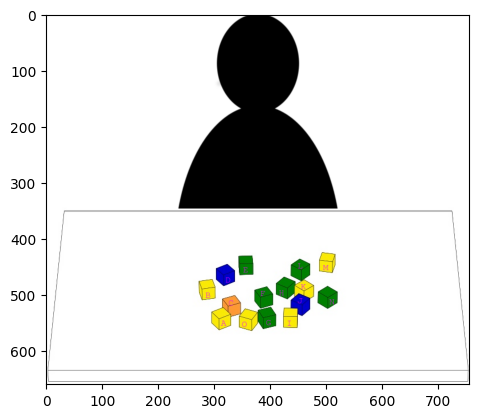

In [ ]:
i = random.randint(0, len(test_ds_as_is) - 1)

# show the sample dataset with image
# display image from dataset
plt.imshow(test_ds_as_is[i][scenario])

print("Description: ", test_ds_as_is[i]["description"])
print("Answer: ", test_ds_as_is[i]["answer"])

In [ ]:
prompts = []
prompts.append(
    [
        "Instruction: Output only the letter of the block corresponding to following description, nothing else.Descriptions are from the perspective of the black figure looking forward at the table.\n",
        test_ds_as_is[scenario][i],
        f"Description: {test_ds_as_is['description'][i]}, Answer:",
    ],
)
response = check_inference(model, processor, prompts, max_new_tokens=1)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [ ]:
# Initialize counts for correct and incorrect answers
correct_count = 0
incorrect_count = 0

# Iterate over each prompt in the test dataset
for i in range(len(test_ds_as_is)):
    prompt = [
        "Instruction: Output only the letter of the block corresponding to following description, nothing else.Descriptions are from the perspective of the black figure looking forward at the table.\n",
        test_ds_as_is[scenario][i],
        f"Description: {test_ds_as_is['description'][i]}, Answer:",
    ]

    # Run inference for the prompt
    response = check_inference(model, processor, [prompt], max_new_tokens=1)

    # Extract the predicted answer
    predicted_answer = response[-1]

    # Get the correct answer from the dataset
    correct_answer = test_ds_as_is[i]["answer"]

    # Check if the predicted answer matches the correct answer
    if predicted_answer == correct_answer:
        correct_count += 1
    else:
        incorrect_count += 1

# Print the counts
print("Correct answers:", correct_count)
print("Incorrect answers:", incorrect_count)


Correct answers: 7
Incorrect answers: 143
